In [12]:
%load_ext autoreload
%autoreload 2

import numpy as np
import grd
import visualisation as vis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


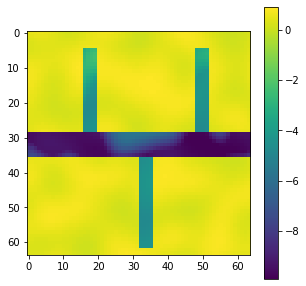

In [29]:
import river as rv

relief_width = 64
relief_height = 64
relief_smooth = 0.1

# Base relief
relief_vals = np.fromfunction(
    function=np.vectorize(lambda x, y: rv.relief_noise(x * relief_smooth, y * relief_smooth)),
    shape=(relief_height, relief_width)
)

# Main river
main_river_params = rv.MainRiverParams(
    width=6,
    depth=-10,
    relief_shape=relief_vals.shape
)
main_river = rv.create_main_river(main_river_params)

# Side rivers with river lands
river_lands_params = rv.RiverLandsParams(
    main_river=main_river,
    width=3,
    depth=-5,
    count=3,
    smooth=0.1,
    relief_shape=relief_vals.shape
)
river_lands = rv.create_river_lands(river_lands_params)

relief_vals = rv.dig_river(main_river, relief_vals)
for river_land in river_lands:
    relief_vals = rv.dig_river(river_land.river, relief_vals)
vis.draw_map(relief_vals)

In [26]:
import simulation as sim

q_value = 1000
relief_step = 50

source = sim.Source(
    c1=main_river.origin_cells[0],
    c2=main_river.origin_cells[-1], 
    rotate=0, qs=[q_value, q_value]
)

relief_grd = grd.create_map(relief_vals, relief_step)
exp0 = sim.Experiment(relief_grd, it_secs=3600, days=2, sources=[source])
result = sim.run(exp0, 'data/tree-structure/exp0')

TypeError: create_map() missing 2 required positional arguments: 'vals' and 'cell_size'

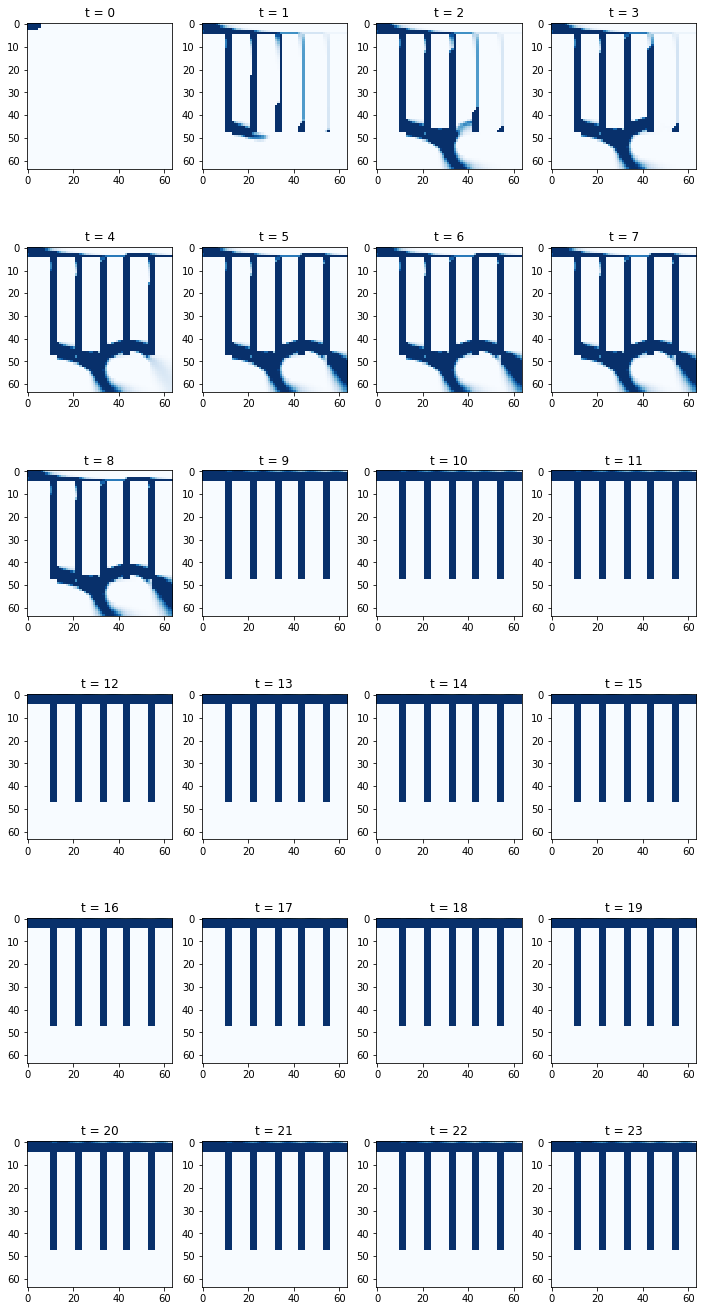

In [53]:
import visualisation as vis
vis.draw_water_distribution(result, 24)

In [ ]:
def get_deltas(exp_result: sim.Result):
    pass

In [144]:
# TODO: move to separate module
def alg(n, d, phis, deltas, M0):
    dp = np.zeros((n, d))
    M = np.zeros((n, d))
    rev = np.zeros((n, d))
    
    def V(u, delta, M):
        return u * delta * M
    
    def ud_to_u(ud):
        return np.interp(ud, range(0, d), [0, 1])
    
    for u1d in range(0, d):
        u1 = ud_to_u(u1d)
        dp[0, u1d] = V(u1, deltas[0], M0)
        
    for k in range(1, n):
        for ukd in range(0, d):
            uk = ud_to_u(ukd)
            opt = 0
            for ukm1d in range(0, d):
                ukm1 = ud_to_u(ukm1d)
                opt = max(opt, dp[k - 1, ukm1] + phis[k](V(ukm1, deltas[k], M[k, ukm1])))
            dp[k, ukd] = opt
